In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from Dilated_Conv_Att import AttDiCEm
from dataset_creation import StockDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [13]:
base_path = "price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [14]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,0.362825,0.364963,0.367482,0.375340,87.121140,0.227562
1,2012-09-05,0.375638,0.366566,0.374189,0.369085,86.509338,0.205288
2,2012-09-06,0.372504,0.369136,0.375768,0.377055,87.288956,0.244032
3,2012-09-07,0.378878,0.374685,0.382305,0.382558,87.827171,0.200546
4,2012-09-10,0.382012,0.375758,0.364325,0.359201,85.542564,0.312446


In [17]:
feature_columns = ['Open','High','Low','Close','Volume']
# feature_columns = ['Close']
filtered_df = df[feature_columns]
seq_len = 10
train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size]
test_data = filtered_df.iloc[train_size:]


In [18]:
try:
    train_dataset = StockDataset(train_data, seq_len, feature_columns)
    test_dataset = StockDataset(test_data, seq_len, feature_columns)
    print("Datasets created successfully!")
except Exception as e:
    print(f"Error creating dataset: {e}")

Datasets created successfully!


In [19]:
train_dataset[0]

(tensor([[0.3628, 0.3650, 0.3675, 0.3753, 0.2276],
         [0.3756, 0.3666, 0.3742, 0.3691, 0.2053],
         [0.3725, 0.3691, 0.3758, 0.3771, 0.2440],
         [0.3789, 0.3747, 0.3823, 0.3826, 0.2005],
         [0.3820, 0.3758, 0.3643, 0.3592, 0.3124],
         [0.3620, 0.3583, 0.3570, 0.3564, 0.3237],
         [0.3642, 0.3580, 0.3563, 0.3685, 0.4709],
         [0.3780, 0.3787, 0.3810, 0.3859, 0.3904],
         [0.3944, 0.3939, 0.3982, 0.3969, 0.3919],
         [0.4067, 0.3976, 0.4071, 0.4081, 0.2489]]),
 tensor(0.4109))

In [20]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Epoch 1/30, Loss: 0.004999543074518442
Epoch 2/30, Loss: 0.00043408750207163393
Epoch 3/30, Loss: 0.0004813161795027554
Epoch 4/30, Loss: 0.00015487539349123836
Epoch 5/30, Loss: 0.0011404633987694979
Epoch 6/30, Loss: 0.0002851245808415115
Epoch 7/30, Loss: 0.00038644985761493444
Epoch 8/30, Loss: 0.0028797828126698732
Epoch 9/30, Loss: 0.0008697275770828128
Epoch 10/30, Loss: 0.0002909227041527629
Epoch 11/30, Loss: 0.0002058766840491444
Epoch 12/30, Loss: 0.0003244994150009006
Epoch 13/30, Loss: 0.0017252161633223295
Epoch 14/30, Loss: 9.354037320008501e-05
Epoch 15/30, Loss: 0.00047987757716327906
Epoch 16/30, Loss: 0.0001889177947305143
Epoch 17/30, Loss: 0.00029952844488434494
Epoch 18/30, Loss: 0.0002590106159914285
Epoch 19/30, Loss: 0.0016824317863211036
Epoch 20/30, Loss: 0.00041929617873393
Epoch 21/30, Loss: 0.00039839197415858507
Epoch 22/30, Loss: 0.00030707247788086534
Epoch 23/30, Loss: 0.00011947711027460173
Epoch 24/30, Loss: 0.0002512844221200794
Epoch 25/30, Loss: 0

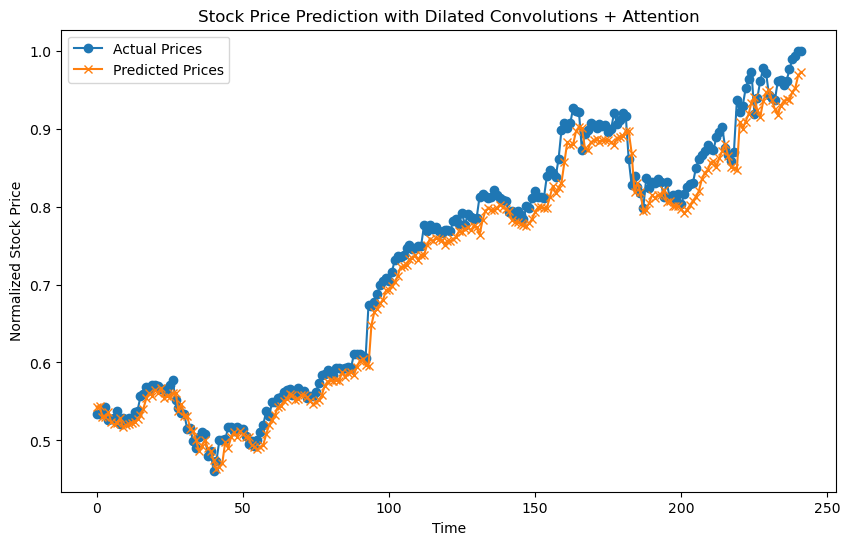

In [21]:
# Define the new model
input_size = len(feature_columns)  # Number of features
hidden_size = 64  # Number of output channels from CNN
model = AttDiCEm(input_size=input_size, hidden_size=hidden_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title('Stock Price Prediction with Dilated Convolutions + Attention')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()
